In [ ]:
# Install PyTorch in Google Colab
!pip install torch torchvision

# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import product
import time

In [ ]:
# Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
columns = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight',
           'VisceraWeight', 'ShellWeight', 'Rings']
df = pd.read_csv(url, header=None, names=columns)

In [ ]:
# Encode Categorical Variable
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])


In [ ]:
# Features and Target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Scale Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Convert target to classification task (Rings -> Age groups)
y = np.digitize(y, bins=[8, 12], right=True)  # 0: young, 1: medium, 2: old

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

In [ ]:
# Define MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPClassifier, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(activation_fn)
            current_size = hidden_size
        layers.append(nn.Linear(current_size, 3))  # 3 classes (young, medium, old)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Define Function for Training and Evaluation
def train_and_evaluate(hidden_layers, activation_fn, learning_rate, batch_size, epochs):
    model = MLPClassifier(input_size=X.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    return correct / total

In [ ]:

# Hyperparameters to Compare
hidden_layer_configs = [[4], [8], [16], [32], [64], [4, 8], [16, 32, 64]]
activation_functions = [nn.Identity(), nn.Sigmoid(), nn.ReLU(), nn.Tanh()]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]
epochs_list = [1, 10, 25, 50, 100, 250]

In [ ]:
import random
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Function to train and evaluate a model (similar to your original train_and_evaluate)
def train_and_evaluate(hidden_layers, activation_fn, learning_rate, batch_size, epochs):
    model = MLPClassifier(input_size=X.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(y_batch.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Defining hyperparameter space
hidden_layer_configs = [[4], [8], [16], [32], [64], [4, 8], [16, 32, 64]]
activation_functions = [nn.Identity(), nn.Sigmoid(), nn.ReLU(), nn.Tanh()]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]
epochs_list = [1, 10, 25, 50, 100, 250]

# Randomized Search Manual Implementation
results = []
n_iter = 20  # Number of random combinations to try

for _ in range(n_iter):
    # Randomly choose a combination of hyperparameters
    hidden_layers = random.choice(hidden_layer_configs)
    activation_fn = random.choice(activation_functions)
    learning_rate = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    epochs = random.choice(epochs_list)

    # Train and evaluate model with the chosen hyperparameters
    accuracy = train_and_evaluate(hidden_layers, activation_fn, learning_rate, batch_size, epochs)

    # Store the results
    results.append({
        "Hidden Layers": hidden_layers,
        "Activation": activation_fn.__class__.__name__,
        "Learning Rate": learning_rate,
        "Batch Size": batch_size,
        "Epochs": epochs,
        "Accuracy": accuracy
    })

# Convert results to DataFrame and sort by accuracy
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Accuracy", ascending=False).head(10))


   Hidden Layers Activation  Learning Rate  Batch Size  Epochs  Accuracy
11        [4, 8]    Sigmoid         0.0100          64     250  0.726077
19        [4, 8]   Identity         0.0010         128     250  0.706938
14          [32]    Sigmoid         0.0100          16     250  0.705742
17  [16, 32, 64]   Identity         0.0100          16      25  0.703349
0           [64]       ReLU         0.0001          32     100  0.702153
2           [32]   Identity         1.0000         256     100  0.680622
12           [8]       ReLU         0.0001          16      50  0.677033
5           [32]    Sigmoid         1.0000          16      10  0.669856
15        [4, 8]       ReLU         0.0001         256     250  0.667464
18          [64]   Identity         1.0000          64      25  0.663876


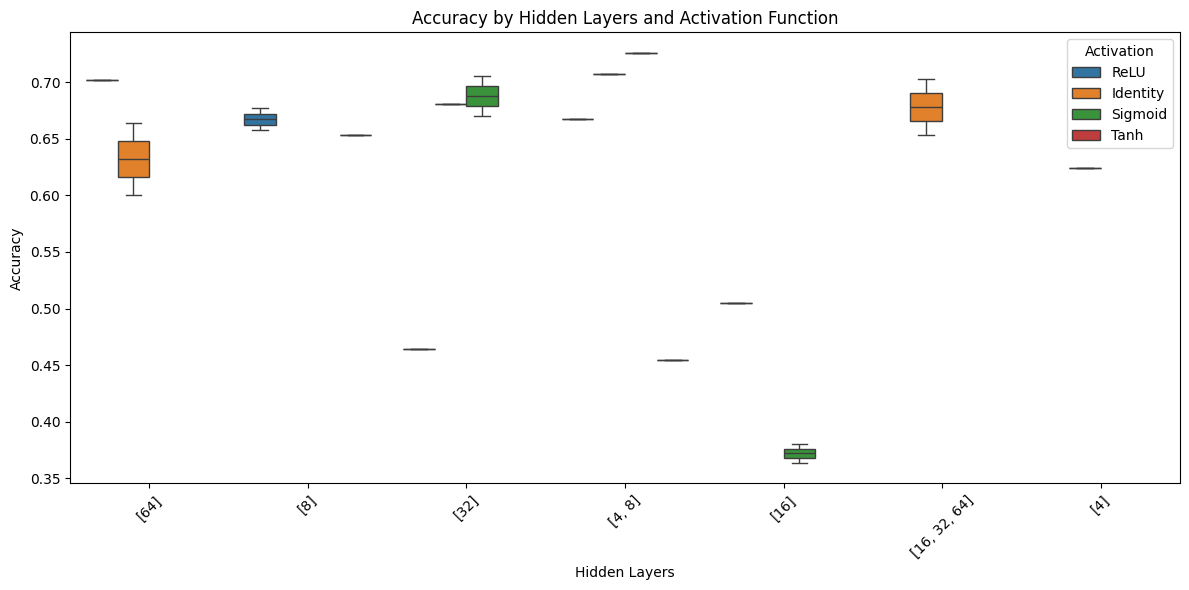

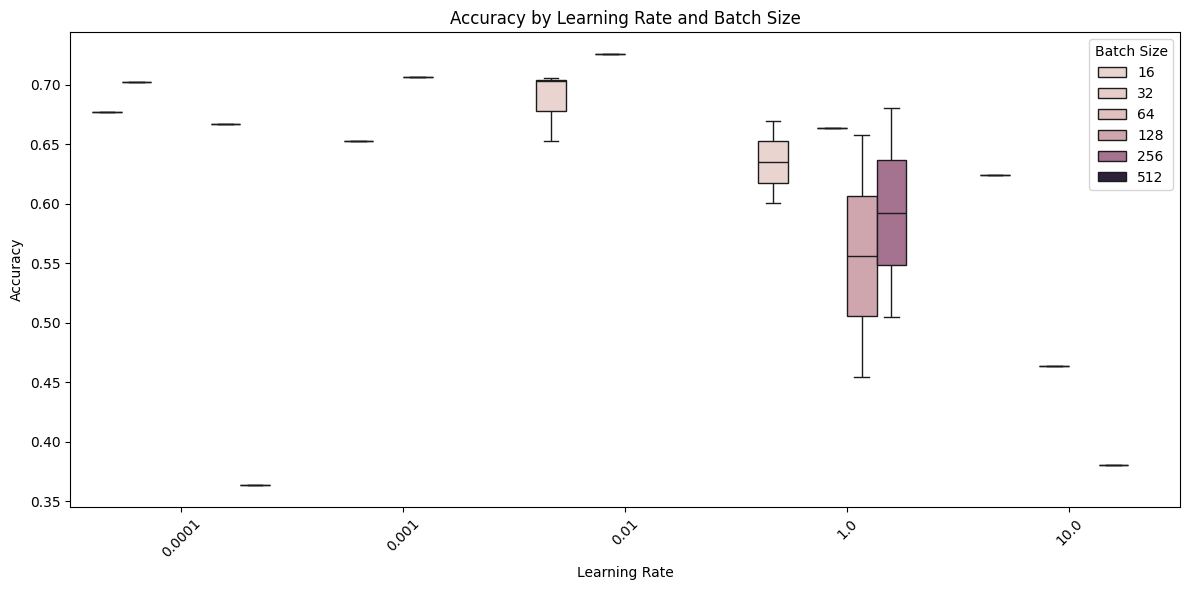

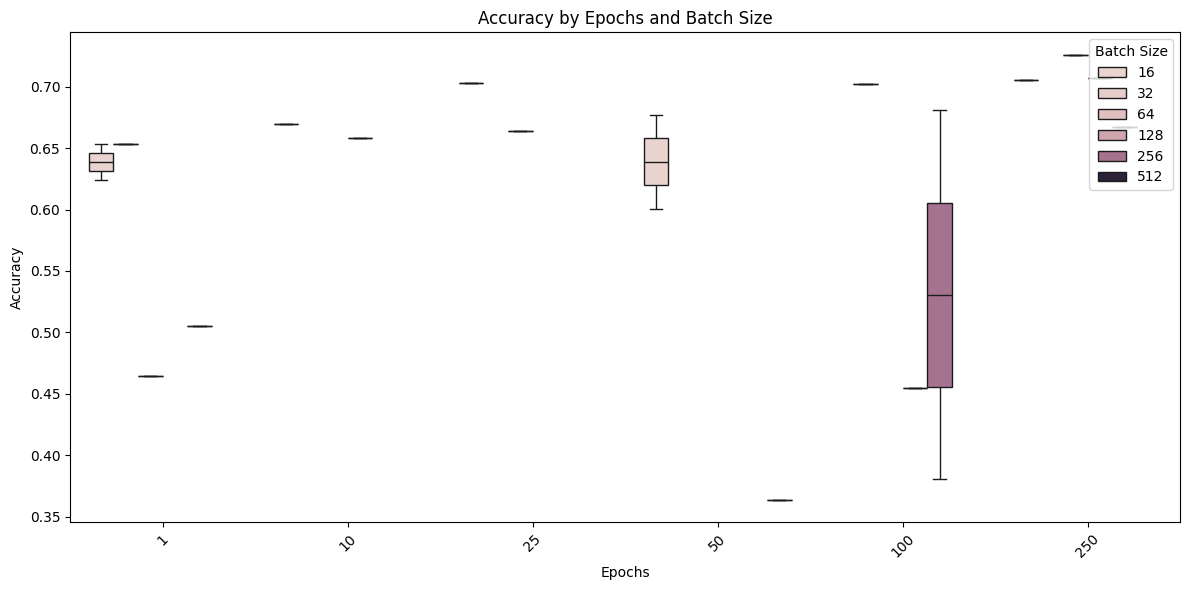

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Function to Compare Results
def plot_results(results_df, x_param, hue_param, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=results_df, x=x_param, y="Accuracy", hue=hue_param)
    plt.title(title)
    plt.xlabel(x_param)
    plt.ylabel("Accuracy")
    plt.legend(title=hue_param, loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Convert lists in columns to strings for better visualization
results_df["Hidden Layers"] = results_df["Hidden Layers"].apply(lambda x: str(x))

# Plot Hidden Layers vs Accuracy
plot_results(results_df, x_param="Hidden Layers", hue_param="Activation",
             title="Accuracy by Hidden Layers and Activation Function")

# Plot Learning Rate vs Accuracy
plot_results(results_df, x_param="Learning Rate", hue_param="Batch Size",
             title="Accuracy by Learning Rate and Batch Size")

# Plot Epochs vs Accuracy
plot_results(results_df, x_param="Epochs", hue_param="Batch Size",
             title="Accuracy by Epochs and Batch Size")